In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Data Loading

Objective: Provide context about the dataset and load it for analysis.

In [2]:
# Path to the CSV file
file_path = "../data/bank-full.csv"

# Load the data
data = pd.read_csv(file_path, sep=';')

# Preview the first few rows
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Step 2: Data Cleaning and Missing Value Handling

Objective: Standardize missing values, clean data, and remove irrelevant columns.

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64


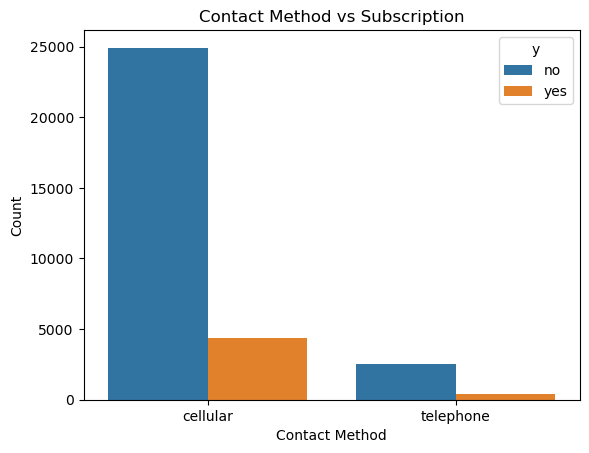

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
y            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  y          45211 non-nul

In [3]:
# Replace "unknown" with NaN
data.replace('unknown', np.nan, inplace=True)

# Check for missing values
print(data.isnull().sum())

# Visualize the relationship between 'contact' and 'y' to evaluate its importance
sns.countplot(x='contact', hue='y', data=data)
plt.title('Contact Method vs Subscription')
plt.xlabel('Contact Method')
plt.ylabel('Count')
plt.show()

# Impute missing values in 'job' and 'education' with mode
data['job'] = data['job'].fillna(data['job'].mode()[0])
data['education'] = data['education'].fillna(data['education'].mode()[0])

# Decision about 'contact':
# Based on the visualization, replace missing values in 'contact' with 'Unknown Contact'
data['contact'] = data['contact'].fillna('Unknown Contact')

# Drop the 'poutcome' column due to excessive missing values
data.drop(columns=['poutcome'], inplace=True)

# Drop the 'duration' column as it is deemed irrelevant
data.drop(columns=['duration'], inplace=True)

# Verify the cleaned dataset
print(data.isnull().sum())
print(data.info())


To prepare the dataset for analysis, we addressed missing values and removed irrelevant columns. Missing values in job and education were imputed with the mode, as their proportions were small, and mode imputation preserves their categorical nature. For contact, we visualized its relationship with the target variable (y) and found that contact method correlates with subscription rates. Based on this insight, missing values in contact were replaced with "Unknown Contact" to retain its predictive value. Columns like poutcome, which had excessive missing values (82%), were dropped to reduce noise, while duration was removed to prevent data leakage, as it directly correlates with the target variable. These cleaning decisions ensure a clean, consistent dataset, while preserving key patterns for predictive modeling.

## Step 3: Exploratory Data Analysis (EDA)

Objective: Gain insights into the dataset using summary statistics and visualizations.

### 3.1 Summary Statistics Code

In [4]:
# Generate summary statistics for numerical columns
print(data.describe())

                age        balance           day      campaign         pdays  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419      2.763841     40.197828   
std       10.618762    3044.765829      8.322476      3.098021    100.128746   
min       18.000000   -8019.000000      1.000000      1.000000     -1.000000   
25%       33.000000      72.000000      8.000000      1.000000     -1.000000   
50%       39.000000     448.000000     16.000000      2.000000     -1.000000   
75%       48.000000    1428.000000     21.000000      3.000000     -1.000000   
max       95.000000  102127.000000     31.000000     63.000000    871.000000   

           previous  
count  45211.000000  
mean       0.580323  
std        2.303441  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


The summary statistics provide an overview of the central tendencies, variability, and range of the numerical columns in the dataset. The age column, with a mean of 41 years and a standard deviation of 10.6, indicates a diverse range from 18 to 95 years. The balance column shows significant variability, with a wide range from -8019 to 102127 and a standard deviation over 3000, suggesting the presence of outliers. The day column, representing the last contact day, is evenly distributed across the month, while campaign has a median of 2 and a maximum of 63, showing that most clients were contacted only a few times. The pdays column has many entries with -1, likely indicating no prior contact, while previous has a low mean (0.58) but a maximum of 275, highlighting infrequent yet extreme cases. These statistics offer critical insights into the dataset’s distribution and help identify features that may need further preprocessing.

### 3.2 Distribution of the Target Variable

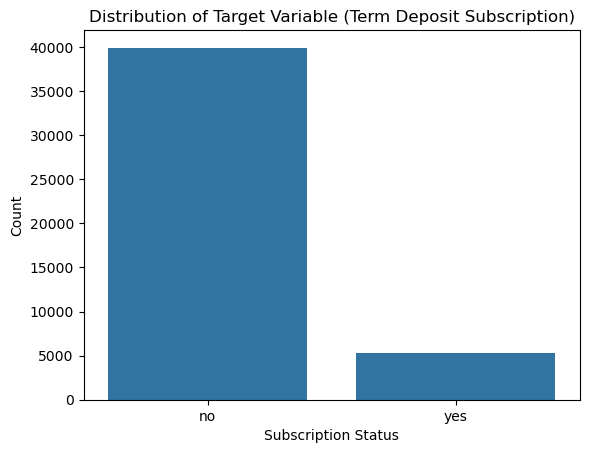

In [5]:
# Visualize the distribution of the target variable
sns.countplot(x='y', data=data)
plt.title('Distribution of Target Variable (Term Deposit Subscription)')
plt.xlabel('Subscription Status')
plt.ylabel('Count')
plt.show()


### 3.3 Relationships Between Features and Target Code:

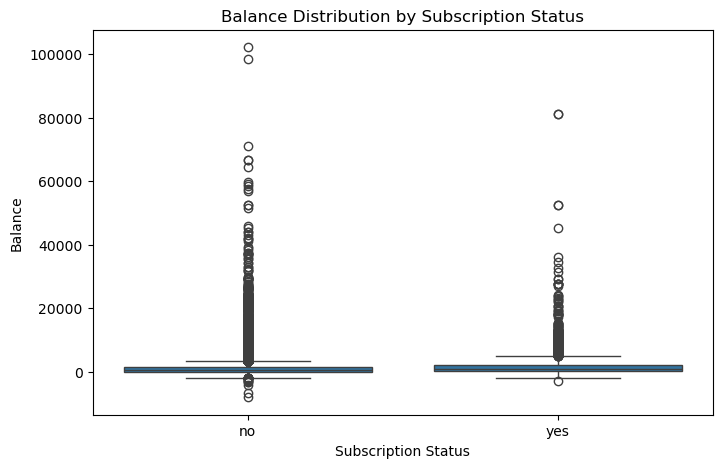

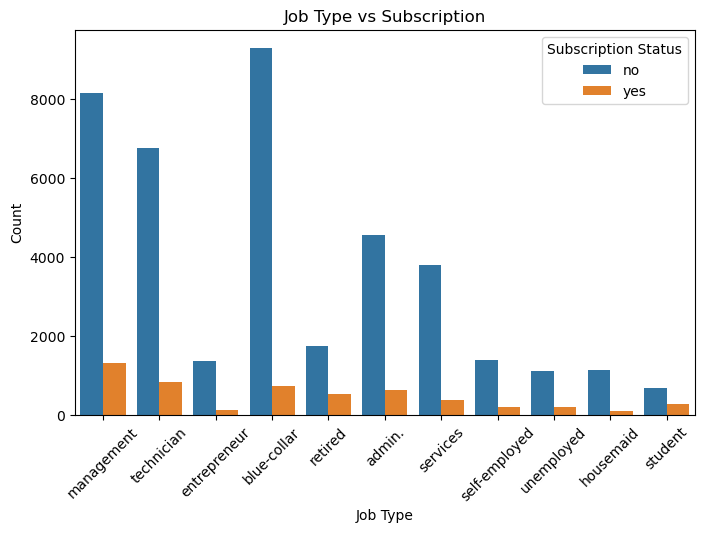

In [6]:
# Set a consistent figure size
plot_size = (8, 5)

# Boxplot for balance vs subscription status
plt.figure(figsize=plot_size)
sns.boxplot(x='y', y='balance', data=data)
plt.title('Balance Distribution by Subscription Status')
plt.xlabel('Subscription Status')
plt.ylabel('Balance')
plt.show()

# Job vs subscription
plt.figure(figsize=plot_size)
sns.countplot(x='job', hue='y', data=data)
plt.title('Job Type vs Subscription')
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Subscription Status', loc='upper right')
plt.show()

## Step 4. Correlation Analysis

Objective: Explore relationships between numerical features.

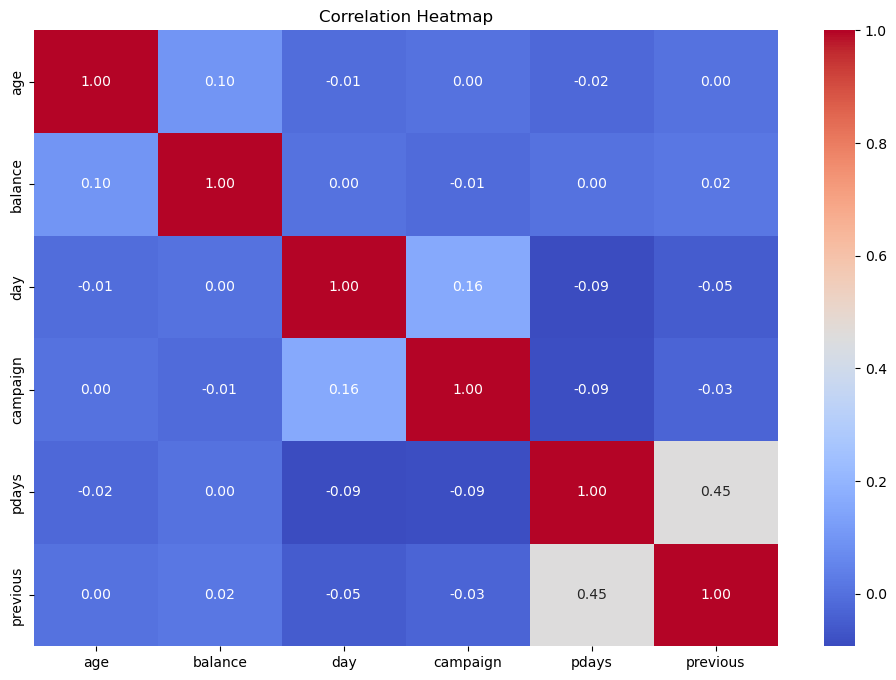

In [7]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate and visualize the correlation matrix
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap reveals that most numerical features have weak or negligible correlations, indicating low multicollinearity and diverse contributions to prediction. A notable moderate correlation (0.45) exists between pdays and previous, suggesting some redundancy, but other features like age, balance, and campaign show minimal linear relationships. This suggests that the numerical features are largely independent and suitable for modeling without significant concerns about collinearity.